In [2]:
!pip3 install -r requirements.txt

  Obtaining dependency information for pillow>=7.0.0 from https://files.pythonhosted.org/packages/b7/ad/71982d18fd28ed1f93c31b8648f980ebdbdbcf7d8c9c9b4af59290914ce9/Pillow-10.0.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for requests>=2.20.0 from https://files.pythonhosted.org/packages/70/8e/0e2d847013cb52cd35b38c009bb167a1a26b2ce6cd6965bf26b47bc0bf44/requests-2.31.0-py3-none-any.whl.metadata
  Obtaining dependency information for opencv-python>=4.2.0.32 from https://files.pythonhosted.org/packages/32/a6/4321f0f30ee11d6d85f49251d417f4e885fe7638b5ac50b7e3c80cccf141/opencv_python-4.8.0.76-cp37-abi3-macosx_11_0_arm64.whl.metadata
  Using cached opencv_python-4.8.0.76-cp37-abi3-macosx_11_0_arm64.whl.metadata (19 kB)
  Obtaining dependency information for tqdm>=4.23.0 from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [116]:
import pandas as pd
df = pd.read_csv('GPTNameTHEN.txt', sep=".", header=None, index_col=0)

In [117]:
df.columns = ["Name"]
df.head()

,Name
0,
1,สมชาย ใจดี (Somchai Jai Dee)
2,รุ่งทิวา สวยงาม (Rungtiwa Suayngam)
3,ภัทราพร รักชาติ (Patharaporn Rukchat)
4,อรวรรณ มีรักษ์ (Orawan Mee-rak)
5,ณัฐวรรณ สุขใจ (Nattawan Sukjai)


In [118]:
import regex as re
def en_th_sep(name = 'name'):
    name = name.split('(')
    name[1] = name[1].replace(')', '')
    name[0] = name[0].strip()
    if re.search(r'[ก-๙]', name[0]):
        return name[1], name[0]
    else:
        return name[0], name[1]

In [119]:
df['en'], df['th'] = zip(*df['Name'].map(en_th_sep))

In [120]:
df = df.drop(columns=['Name'])
df.head()

,en,th
0,,
1,Somchai Jai Dee,สมชาย ใจดี
2,Rungtiwa Suayngam,รุ่งทิวา สวยงาม
3,Patharaporn Rukchat,ภัทราพร รักชาติ
4,Orawan Mee-rak,อรวรรณ มีรักษ์
5,Nattawan Sukjai,ณัฐวรรณ สุขใจ


In [121]:
from trdg.utils import mask_to_bboxes, draw_bounding_boxes

In [164]:
from trdg.generators import (
    GeneratorFromStrings )

# The generators use the same arguments as the CLI, only as parameters
generator = GeneratorFromStrings(
    df['th'].tolist() + df['en'].tolist(),
    # ['พ่อ', 'ลุง', 'ฉัน', 'ญู', 'นั่น', 'น่ัน', 'พี่', 'พ่ี', 'นู้น', 'นั้น', 'น้ำ', 'นำ้', 'ปำ', 'ฝ่ำ'],
    blur=0,
    random_blur=False,
    language='th',
    count=len(df['th'].tolist())*2,
    # count=14,
    fonts=[
        'trdg/fonts/th/upcdb.ttf', 
        # 'trdg/fonts/th/upcdbi.ttf',
        # 'trdg/fonts/th/upcdi.ttf', 
        'trdg/fonts/th/upcdl.ttf',
    ],
    size=64,
    background_type=3,
    image_dir='thai_id_bg/',
    margins = (5,5,5,5),
    output_mask=True,
    output_bboxes=3,
)   

In [165]:
from trdg.computer_text_generator import TH_TONE_MARKS, TH_UNDER_VOWELS, TH_UPPER_VOWELS, TH_SARA_AM
from trdg.computer_text_generator import th_grouping
def th_tone_vowel_bbox_sep(lbl, bboxes):
    splitted_text = th_grouping(lbl)
    # print(splitted_text)
    # print(bboxes)
    new_bboxes = []
    for i, s in enumerate(splitted_text):
        bbox = bboxes[i]
        len_s = len(s)
        if len_s > 1 and s != 'ญู' and s != 'ญุ':
            if len_s == 2 :
                s2 = "{0:#x}".format(ord(s[1]))
                if s2 in TH_TONE_MARKS: # tone only
                    h = bbox[3] - bbox[1]
                    tone_bbox = (bbox[0], bbox[1], bbox[2], bbox[1]+round(h*0.3))
                    new_bboxes.append(tone_bbox) 
                    alpha_bbox = (bbox[0], bbox[1] + round(h*0.3), bbox[2], bbox[3])
                    new_bboxes.append(alpha_bbox)
                elif s2 in TH_UPPER_VOWELS: # upper_vowel only
                    h = bbox[3] - bbox[1]
                    upper_vowel_bbox = (bbox[0], bbox[1], bbox[2], bbox[1]+round(h*0.3))
                    new_bboxes.append(upper_vowel_bbox)
                    alpha_bbox = (bbox[0], bbox[1] + round(h*0.3), bbox[2], bbox[3])
                    new_bboxes.append(alpha_bbox)
                elif s2 in TH_UNDER_VOWELS: # under_vowel only
                    h = bbox[3] - bbox[1]
                    alpha_bbox = (bbox[0], bbox[1], bbox[2], bbox[1]+round(h*0.7))
                    new_bboxes.append(alpha_bbox)
                    under_vowel_bbox = (bbox[0], bbox[1]+round(h*0.7), bbox[2], bbox[3])
                    new_bboxes.append(under_vowel_bbox)
                elif s2 in TH_SARA_AM: # sara_am only
                    if s[0] in ['ป', 'ฝ']:
                        w = bbox[2] - bbox[0]
                        alpha_bbox = (bbox[0], bbox[1], bbox[0]+round(w*0.6), bbox[3])
                        new_bboxes.append(alpha_bbox)
                        sara_am_bbox = (bbox[0]+round(w*0.2), bbox[1], bbox[2], bbox[3])
                        new_bboxes.append(sara_am_bbox)
                    else :
                        w = bbox[2] - bbox[0]
                        alpha_bbox = (bbox[0], bbox[1], bbox[0]+round(w*0.6), bbox[3])
                        new_bboxes.append(alpha_bbox)
                        sara_am_bbox = (bbox[0]+round(w*0.4), bbox[1], bbox[2], bbox[3])
                        new_bboxes.append(sara_am_bbox)
                    
                else :
                    new_bboxes.append(bbox)
            elif len_s == 3 :
                s2 = "{0:#x}".format(ord(s[1]))
                s3 = "{0:#x}".format(ord(s[2]))
                if s2 in TH_UPPER_VOWELS and s3 in TH_TONE_MARKS: # upper_vowel + tone
                    h = bbox[3] - bbox[1]
                    tone_bbox = (bbox[0], bbox[1], bbox[2], bbox[1]+round(h*0.23))
                    new_bboxes.append(tone_bbox)
                    upper_vowel_bbox = (bbox[0], bbox[1]+round(h*0.23), bbox[2], bbox[1]+round(h*0.5))
                    new_bboxes.append(upper_vowel_bbox)
                    alpha_bbox = (bbox[0], bbox[1]+round(h*0.5), bbox[2], bbox[3])
                    new_bboxes.append(alpha_bbox)
                
                elif s2 in TH_UNDER_VOWELS and s3 in TH_TONE_MARKS: # under_vowel + tone    
                    h = bbox[3] - bbox[1]
                    tone_bbox = (bbox[0], bbox[1], bbox[2], bbox[1]+round(h*0.23))
                    new_bboxes.append(tone_bbox)
                    alpha_bbox = (bbox[0], bbox[1]+round(h*0.23), bbox[2], bbox[1]+round(h*0.72))
                    new_bboxes.append(alpha_bbox)
                    under_vowel_bbox = (bbox[0], bbox[1]+round(h*0.72), bbox[2], bbox[3])
                    new_bboxes.append(under_vowel_bbox)
                elif s2 in TH_TONE_MARKS and s3 in TH_SARA_AM: # sara_am + tone
                    h = bbox[3] - bbox[1]
                    tone_bbox = (bbox[0], bbox[1], bbox[2], bbox[1]+round(h*0.25))
                    new_bboxes.append(tone_bbox)
                    sara_am_bbox = (bbox[0], bbox[1]+round(h*0.3), bbox[2], bbox[3])
                    if s[0] in ['ป', 'ฝ']:
                        w = bbox[2] - bbox[0]
                        alpha_bbox = (sara_am_bbox[0], sara_am_bbox[1], sara_am_bbox[0]+round(w*0.6), sara_am_bbox[3])
                        new_bboxes.append(alpha_bbox)
                        sara_am_bbox = (sara_am_bbox[0]+round(w*0.2), sara_am_bbox[1], sara_am_bbox[2], sara_am_bbox[3])
                        new_bboxes.append(sara_am_bbox)
                    else :
                        w = bbox[2] - bbox[0]
                        alpha_bbox = (sara_am_bbox[0], sara_am_bbox[1], sara_am_bbox[0]+round(w*0.6), sara_am_bbox[3])
                        new_bboxes.append(alpha_bbox)
                        sara_am_bbox = (sara_am_bbox[0]+round(w*0.4), sara_am_bbox[1], sara_am_bbox[2], sara_am_bbox[3])
                        new_bboxes.append(sara_am_bbox)
                else :
                    new_bboxes.append(bbox)
        else :
            new_bboxes.append(bbox)
    # print(new_bboxes)
    return splitted_text, new_bboxes

In [166]:
# from PIL import ImageDraw
# for (img, mask), lbl in generator:
#     bboxes = mask_to_bboxes(mask)
#     lbl, bboxes = th_tone_vowel_bbox_sep(lbl, bboxes)
#     lbl = ''.join(lbl)
#     print(lbl)
#     print(f'{len(bboxes)} bboxes : {len(lbl)} chars')
#     d = ImageDraw.Draw(img)
#     for bbox in bboxes:
#         d.rectangle(bbox, outline="green")
#     display(img)

In [167]:
import time
import os
from tqdm import tqdm
from pyblp import save_pickle

def current_milli_time():
    return round(time.time() * 1000)

project_dir = 'ThaiID'
full_path =os.path.dirname(os.path.realpath("__file__"))
project_dir = os.path.join(full_path,project_dir)
dirname = 'train'
dir_path = os.path.join(project_dir,dirname)
os.makedirs(dir_path,exist_ok=True)
texts = []
save_dir_img =os.path.join(dir_path,'imgs')
# rmtree(save_dir_img,ignore_errors=True)
os.makedirs(save_dir_img,exist_ok=True)

save_dir_bbox =os.path.join(dir_path,'bbox')
# rmtree(save_dir_bbox,ignore_errors=True)
os.makedirs(save_dir_bbox,exist_ok=True)

save_dir_mask =os.path.join(dir_path,'mask')
# rmtree(save_dir_mask,ignore_errors=True)
os.makedirs(save_dir_mask,exist_ok=True)

for i in tqdm(generator):
    if i[0]:
        (img, mask), lbl = i
        try:
            # lbl = lbl.replace('—','')
            # display(img)
            bboxes = mask_to_bboxes(mask)
            lbl, bboxes = th_tone_vowel_bbox_sep(lbl, bboxes)
            lbl = ''.join(lbl)
            timestamp = current_milli_time()
            filename = f'{timestamp}.jpg'
            filename_mask = f'{timestamp}.png'
            bbox_filename = f'{timestamp}.pkl'
            image_path = os.path.join(save_dir_img,filename)
            bbox_path = os.path.join(save_dir_bbox,bbox_filename)

            mask_path = os.path.join(save_dir_mask,filename_mask)
            save_pickle(bboxes, bbox_path)
            # txt_imagepath =os.path.join('test',filename)

            # resized = img.resize((340,70))
            img.save(image_path)
            mask.save(mask_path)
            texts.append(f'{filename} {lbl}\n')
        # print(lbl)
        except Exception as e:
            print(e)
            print(lbl)
with open(os.path.join(dir_path,'gt.txt'),'a') as f:
    f.writelines(''.join(texts))

200it [00:05, 39.40it/s]


# Test with a single image

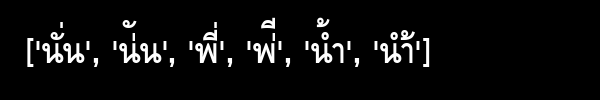

In [7]:
from PIL import Image, ImageFont, ImageDraw

text_string = str(['นั่น', 'น่ัน', 'พี่', 'พ่ี', 'น้ำ', 'นำ้'])

img = Image.new('RGB', (600, 100))
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('trdg/fonts/th/upcdb.ttf', 50, layout_engine=ImageFont.Layout.RAQM)

draw.text((25,40), text_string, fill='white', font=font)

display(img)